# Swiggy Rating Prediction

--------------------------------------------------------
# 1. Understanding problem statment


#### Problem Statement:- Predicting Rating Category of Swiggy based on various factors.
#### Target column :- `Rating_Category`

-------------------------------------
### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from IPython.display import Markdown
import mysql.connector

warnings.filterwarnings("ignore")

------
# 2. Data Reading and Understanding

In [2]:
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "root",
    "database": "mydatabase"
}
conn = mysql.connector.connect(**db_config)

In [3]:
query = "SELECT * FROM restaurant_data"

df = pd.read_sql(query, conn)
df.head()

,ID,Area,City,Restaurant,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Chinese,Indian,Beverages,Snacks,Desserts,North_Indian,Fast_Food,Biryani,Rating_Category
0,1,Koramangala,Bangalore,Tandoor Hut,300,100,59,4595,Yes,No,No,No,No,Yes,No,Yes,Good Rating
1,2,Koramangala,Bangalore,Tunday Kababi,300,100,56,5411,No,No,No,No,No,No,No,No,Good Rating
2,3,Jogupalya,Bangalore,Kim Lee,650,100,25,5403,Yes,No,No,No,No,No,No,No,Good Rating
3,4,Indiranagar,Bangalore,New Punjabi Hotel,250,500,57,5188,No,No,No,No,No,Yes,No,No,Good Rating
4,5,Indiranagar,Bangalore,Nh8,350,50,63,5211,No,No,Yes,Yes,Yes,Yes,No,No,Low Rating


In [4]:
df.describe()

,ID,Price,Total_Ratings,Delivery_Time,Delivery_Distance
count,8976.000000,8976.000000,8976.000000,8976.000000,8976.000000
mean,4488.500000,400.791667,144.241867,53.373217,5062.495878
std,2591.292342,340.525097,223.292984,14.555267,458.932467
min,1.000000,50.000000,20.000000,20.000000,3371.000000
25%,2244.750000,200.000000,50.000000,43.000000,4740.000000
50%,4488.500000,300.000000,80.000000,52.000000,5048.000000
75%,6732.250000,400.000000,100.000000,63.000000,5354.250000
max,8976.000000,2500.000000,1000.000000,109.000000,7000.000000


In [5]:
df.Rating_Category.value_counts()

Good Rating    6246
Low Rating     2730
Name: Rating_Category, dtype: int64

In [6]:
df.columns

Index(['ID', 'Area', 'City', 'Restaurant', 'Price', 'Total_Ratings',
       'Delivery_Time', 'Delivery_Distance', 'Chinese', 'Indian', 'Beverages',
       'Snacks', 'Desserts', 'North_Indian', 'Fast_Food', 'Biryani',
       'Rating_Category'],
      dtype='object')

In [7]:
df.shape

(8976, 17)

In [8]:
df.ID.nunique()

8976

In [9]:
df.Delivery_Time.describe()

count    8976.000000
mean       53.373217
std        14.555267
min        20.000000
25%        43.000000
50%        52.000000
75%        63.000000
max       109.000000
Name: Delivery_Time, dtype: float64

---------------------------------------------
# 3. Data Cleaning

## 3.1 Missing value treatment

In [10]:
df.isnull().sum()

ID                    0
Area                 16
City                 14
Restaurant           15
Price                 0
Total_Ratings         0
Delivery_Time         0
Delivery_Distance     0
Chinese               0
Indian                0
Beverages             0
Snacks                0
Desserts              0
North_Indian          0
Fast_Food             0
Biryani               0
Rating_Category       0
dtype: int64

In [11]:
df["Area"] = df["Area"].fillna("Sanjay Nagar New Bel Road")
df["City"] = df["City"].fillna("Surat")
#df["Restaurant"] = df["Restaurant"].fillna("Sassy Street")

#df.isnull().sum()

--------------------------
## 3.2 Dropping unique columns

In [12]:
ID = df["ID"]
df = df.drop("ID", axis=1)

Restaurant = df["Restaurant"]
df = df.drop("Restaurant", axis=1)

--------------------------------------
## 3.3 Datatype conversion
#### Dtype conversion using **Label Encoder**

In [13]:
df.dtypes

Area                 object
City                 object
Price                 int64
Total_Ratings         int64
Delivery_Time         int64
Delivery_Distance     int64
Chinese              object
Indian               object
Beverages            object
Snacks               object
Desserts             object
North_Indian         object
Fast_Food            object
Biryani              object
Rating_Category      object
dtype: object

In [14]:
object_columns = df.select_dtypes(include=["object"])
object_column_list = object_columns.columns.tolist()

object_column_list

['Area',
 'City',
 'Chinese',
 'Indian',
 'Beverages',
 'Snacks',
 'Desserts',
 'North_Indian',
 'Fast_Food',
 'Biryani',
 'Rating_Category']

In [15]:
# 3.Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [16]:
for column in object_column_list:
    df[column] = le.fit_transform(df[column])

In [17]:
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'Good Rating': 0, 'Low Rating': 1}


In [18]:
df.dtypes

Area                 int32
City                 int32
Price                int64
Total_Ratings        int64
Delivery_Time        int64
Delivery_Distance    int64
Chinese              int32
Indian               int32
Beverages            int32
Snacks               int32
Desserts             int32
North_Indian         int32
Fast_Food            int32
Biryani              int32
Rating_Category      int32
dtype: object

-----------------------
## 3.4 Checking for Duplicates

In [19]:
print("Total duplicates:", df.duplicated().sum())

Total duplicates: 0


-------------------
# 4. Base Model


### splitting the data in to X & Y  base model before outlier treatment

In [20]:
#splitting the data in to X & Y 
x1=df.drop('Rating_Category', axis=1)
x1.head(2)

,Area,City,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Chinese,Indian,Beverages,Snacks,Desserts,North_Indian,Fast_Food,Biryani
0,353,1,300,100,59,4595,1,0,0,0,0,1,0,1
1,353,1,300,100,56,5411,0,0,0,0,0,0,0,0


In [21]:
y1=df['Rating_Category']
y1.head(2)

0    0
1    0
Name: Rating_Category, dtype: int32

In [22]:
from sklearn.model_selection import train_test_split

x1train, x1test, y1train, y1test = train_test_split(
    x1, y1, test_size=0.2, random_state=30
)
x1train.shape, x1test.shape, y1train.shape, y1test.shape

((7180, 14), (1796, 14), (7180,), (1796,))

In [23]:
from sklearn.metrics import classification_report
def calculate_precision_and_report(predictions, true_labels, model_name='model', data_type='data'):
    # Calculate the classification report
    report = classification_report(predictions, true_labels)

    # Split the classification report into lines
    report_lines = report.split('\n')

    # Extract the precision, recall, and f1-score values for Class 0 and Class 1 from the appropriate lines
    class_0_metrics_line = report_lines[2].strip()  # Assuming metrics for Class 0 are on the third line
    class_1_metrics_line = report_lines[3].strip()  # Assuming metrics for Class 1 are on the fourth line

    # Split the lines to get the precision, recall, and f1-score values
    class_0_metrics = class_0_metrics_line.split()[1:]
    class_1_metrics = class_1_metrics_line.split()[1:]

    # Convert the metrics values to floats (rounded to two decimal places)
    precision_class_0 = float(class_0_metrics[0])
    recall_class_0 = float(class_0_metrics[1])
    f1_score_class_0 = float(class_0_metrics[2])

    precision_class_1 = float(class_1_metrics[0])
    recall_class_1 = float(class_1_metrics[1])
    f1_score_class_1 = float(class_1_metrics[2])

    # Create variables with custom names
    precision0_var = f'{model_name}_precision0_{data_type}'
    precision1_var = f'{model_name}_precision1_{data_type}'
    recall0_var = f'{model_name}_recall0_{data_type}'
    recall1_var = f'{model_name}_recall1_{data_type}'
    f1score0_var = f'{model_name}_f1score0_{data_type}'
    f1score1_var = f'{model_name}_f1score1_{data_type}'
    report_var = f'{model_name}_report_{data_type}'

    # Assign values to the custom variables
    globals()[precision0_var] = precision_class_0
    globals()[precision1_var] = precision_class_1
    globals()[recall0_var] = recall_class_0
    globals()[recall1_var] = recall_class_1
    globals()[f1score0_var] = f1_score_class_0
    globals()[f1score1_var] = f1_score_class_1
    globals()[report_var] = report

    return precision_class_0, precision_class_1, recall_class_0, recall_class_1, f1_score_class_0, f1_score_class_1, report

------------------------------------
### Logistic Regression on base model before outlier treatment

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lg = LogisticRegression()
lg.fit(x1train, y1train)
log_p_1 = lg.predict(x1test)
log_cf_1 = confusion_matrix(log_p_1, y1test)
log_acc_1 = log_cf_1.diagonal().sum() / log_cf_1.sum() * 100

print("Logistic regression before outlier treatment\n")
print(f"Accuracy: {log_acc_1:.2f}%")
print("-"*80,"\nConfusion Matrix:")
print(log_cf_1)
print("-"*80,"\nClassification Report:")
print(classification_report(log_p_1, y1test))

Logistic regression before outlier treatment

Accuracy: 69.04%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1209  504]
 [  52   31]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.81      1713
           1       0.06      0.37      0.10        83

    accuracy                           0.69      1796
   macro avg       0.51      0.54      0.46      1796
weighted avg       0.92      0.69      0.78      1796



In [25]:
calculate_precision_and_report(log_p_1, y1test, model_name='log', data_type='1')

print(f'Precision for Class 0: {log_precision0_1}')
print(f'Precision for Class 1: {log_precision1_1}')

Precision for Class 0: 0.96
Precision for Class 1: 0.06


------------------
### Decision tree on base model before outlier treatment

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x1train, y1train)
dt_p_1 = dt.predict(x1test)
dt_cf_1 = confusion_matrix(dt_p_1, y1test)
dt_acc_1 = dt_cf_1.diagonal().sum() / dt_cf_1.sum() * 100
calculate_precision_and_report(dt_p_1, y1test, model_name='dt', data_type='1')

print("Decision Tree classifier before outlier treatment\n")
print(f"Accuracy: {dt_acc_1:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(dt_cf_1)
print("-" * 80, "\nClassification Report:")
print(classification_report(dt_p_1, y1test))

Decision Tree classifier before outlier treatment

Accuracy: 86.80%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1144  120]
 [ 117  415]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1264
           1       0.78      0.78      0.78       532

    accuracy                           0.87      1796
   macro avg       0.84      0.84      0.84      1796
weighted avg       0.87      0.87      0.87      1796



-----------------------------------
### Random Forest on base model before outlier treatment

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50)
rf.fit(x1train, y1train)
rf_p_1 = rf.predict(x1test)
rf_prob_1 =rf.predict_proba(x1test)
rf_cf_1 = confusion_matrix(rf_p_1, y1test)
rf_acc_1 = rf_cf_1.diagonal().sum() / rf_cf_1.sum() * 100

print("Random Forest classifier before outlier treatment\n")
print(f"Accuracy: {rf_acc_1:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(rf_cf_1)
print("-" * 80, "\nClassification Report:")
print(classification_report(rf_p_1, y1test))

Random Forest classifier before outlier treatment

Accuracy: 91.87%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1152   37]
 [ 109  498]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1189
           1       0.93      0.82      0.87       607

    accuracy                           0.92      1796
   macro avg       0.92      0.89      0.91      1796
weighted avg       0.92      0.92      0.92      1796



In [28]:
calculate_precision_and_report(rf_p_1, y1test, model_name='rf', data_type='1')

print(f'Precision for Class 0: {rf_precision0_1}')
print(f'Precision for Class 1: {rf_precision1_1}')

Precision for Class 0: 0.91
Precision for Class 1: 0.93


AUC-ROC Score: 0.9458329318816842


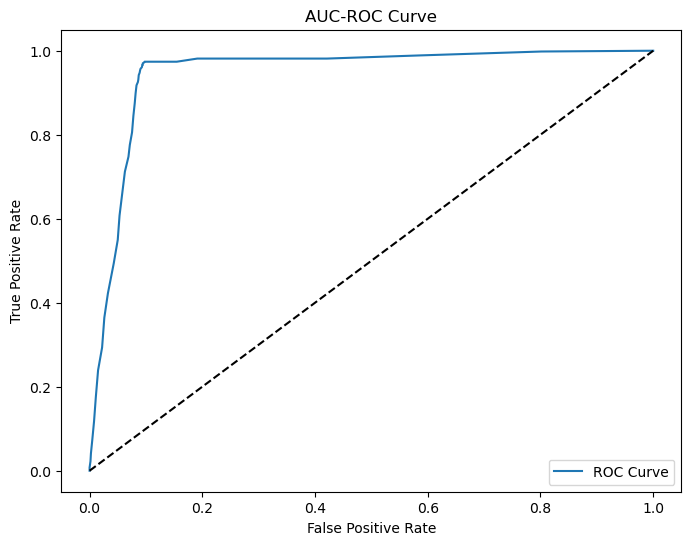

In [29]:
rf_aucdf_1=pd.DataFrame(rf_prob_1)
#rf_aucdf_1
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

rf_prob_1 = rf.predict_proba(x1test)
rf_aucdf_1 = pd.DataFrame(rf_prob_1)

# Calculate the AUC-ROC score
roc = roc_auc_score(y1test, rf_aucdf_1.iloc[:, 1])
print("AUC-ROC Score:", roc)

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y1test, rf_aucdf_1.iloc[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend()
plt.show()

----------------------------
### Naive Bayes on base model before outlier treatment

In [30]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x1train, y1train)
nb_p_1 = nb.predict(x1test)
nb_cf_1 = confusion_matrix(nb_p_1, y1test)
nb_acc_1 = nb_cf_1.diagonal().sum() / nb_cf_1.sum() * 100
calculate_precision_and_report(nb_p_1, y1test, model_name='nb', data_type='1')

print("Naive Bayes classifier before outlier treatment\n")
print(f"Accuracy: {nb_acc_1:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(nb_cf_1)
print("-" * 80, "\nClassification Report:")
print(classification_report(nb_p_1, y1test))


Naive Bayes classifier before outlier treatment

Accuracy: 48.89%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[430  87]
 [831 448]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.83      0.48       517
           1       0.84      0.35      0.49      1279

    accuracy                           0.49      1796
   macro avg       0.59      0.59      0.49      1796
weighted avg       0.69      0.49      0.49      1796



-------------------
### XGB on base model before outlier treatment

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

xgb = XGBClassifier()
xgb.fit(x1train, y1train)
xgb_p_1 = xgb.predict(x1test)
xgb_cf_1 = confusion_matrix(xgb_p_1, y1test)
xgb_acc_1 = xgb_cf_1.diagonal().sum() / xgb_cf_1.sum() * 100
calculate_precision_and_report(xgb_p_1, y1test, model_name='xgb', data_type='1')

print("XGBoost classifier before outlier treatment\n")
print(f"Accuracy: {xgb_acc_1:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(xgb_cf_1)
print("-" * 80, "\nClassification Report:")
print(classification_report(xgb_p_1, y1test))


XGBoost classifier before outlier treatment

Accuracy: 91.59%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1148   38]
 [ 113  497]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1186
           1       0.93      0.81      0.87       610

    accuracy                           0.92      1796
   macro avg       0.92      0.89      0.90      1796
weighted avg       0.92      0.92      0.91      1796



---------------
# Comparision of all Base Models

In [32]:
list_base_1 = ['Logistic','DeisionTree','RandomForest','NB','XGB']
list_base_2 = [log_acc_1,dt_acc_1,rf_acc_1,nb_acc_1,xgb_acc_1]

list_base_3 = [log_precision0_1,dt_precision0_1,rf_precision0_1,nb_precision0_1,xgb_precision0_1]
list_base_4 = [log_precision1_1,dt_precision1_1,rf_precision1_1,nb_precision1_1,xgb_precision1_1]

list_base_5 = [log_recall0_1,dt_recall0_1,rf_recall0_1,nb_recall0_1,xgb_recall0_1]
list_base_6 = [log_recall1_1,dt_recall1_1,rf_recall1_1,nb_recall1_1,xgb_recall1_1]

list_base_7 = [log_f1score0_1,dt_f1score0_1,rf_f1score0_1,nb_f1score0_1,xgb_f1score0_1]
list_base_8 = [log_f1score1_1,dt_f1score1_1,rf_f1score1_1,nb_f1score1_1,xgb_f1score1_1]


final_1 = pd.DataFrame({'modelname':list_base_1,'Accuracy':list_base_2,
                        'Precision 0':list_base_3,'Precision 1':list_base_4,
                        'recall 0':list_base_5,'recall 1':list_base_6,
                        'f1score 0':list_base_7,'f1score 1':list_base_8
                       })
final_1

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,69.042316,0.96,0.06,0.71,0.37,0.81,0.10
1,DeisionTree,86.804009,0.91,0.78,0.91,0.78,0.91,0.78
2,RandomForest,91.870824,0.91,0.93,0.97,0.82,0.94,0.87
3,NB,48.886414,0.34,0.84,0.83,0.35,0.48,0.49
4,XGB,91.592428,0.91,0.93,0.97,0.81,0.94,0.87


<br>

## Observation (Base Model - Before EDA and Feature Selection)
- The **Logistic** model achieved a low overall accuracy **but also struggled to achieve a balanced precision for class 1**.
- The **DecisionTree** model demonstrated respectable accuracy and balanced precision and recall values for both classes.
- The **RandomForest** model, although showing high accuracy, showcased the best balance between precision and recall for both classes.
- The **Naive Bayes (NB)** model exhibited the **lowest overall accuracy and precision**, but it could be considered for its simplicity and potential for class 0 prediction.
- The **XGBoost (XGB)** model presented a competitive balance between accuracy, precision, and recall.

## Conclusion (Base Model - Before EDA and Feature Selection)
- The **RandomForest** model stood out for its balanced performance, making it a strong contender for classification tasks.

-------------------
# Visualization

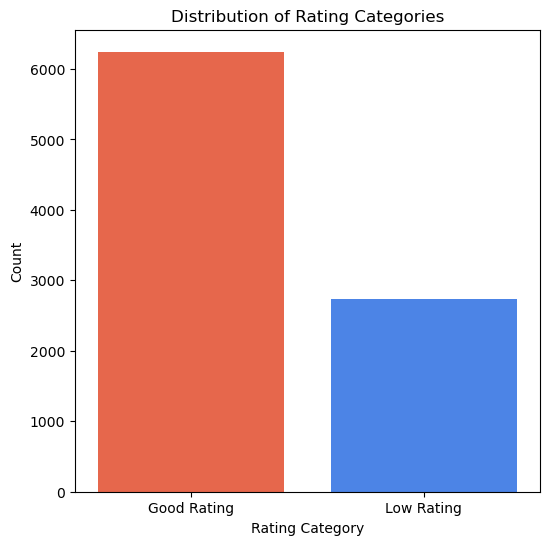

In [33]:
custom_colors = ['#FF5733', '#337DFF']
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='Rating_Category', palette=custom_colors)

plt.xticks([0, 1], ['Good Rating', 'Low Rating'])

plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.title('Distribution of Rating Categories')

plt.show()

In [34]:
df.Rating_Category.value_counts()

0    6246
1    2730
Name: Rating_Category, dtype: int64

#### - The dataset exhibits a significant class imbalance, with "Good Rating" (0) instances outnumbering "Low Rating" (1) instances. 
#### - Addressing this imbalance is crucial for developing an unbiased and accurate machine learning model.

---------------------------
# 5. Class Imbalance (IMB learn oversampling)

In [35]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [36]:
XX=df.drop('Rating_Category', axis=1)
YY=df['Rating_Category']

In [37]:
df.Rating_Category.value_counts()

0    6246
1    2730
Name: Rating_Category, dtype: int64

In [38]:
ab1=RandomOverSampler(random_state=42)
x1,y1=ab1.fit_resample(XX,YY)

In [39]:
x1.shape,y1.shape

((12492, 14), (12492,))

In [40]:
y1.value_counts()

0    6246
1    6246
Name: Rating_Category, dtype: int64

In [41]:
x1.head(2)

,Area,City,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Chinese,Indian,Beverages,Snacks,Desserts,North_Indian,Fast_Food,Biryani
0,353,1,300,100,59,4595,1,0,0,0,0,1,0,1
1,353,1,300,100,56,5411,0,0,0,0,0,0,0,0


In [42]:
oversampled_df = pd.concat([pd.DataFrame(x1), pd.Series(y1, name='Rating_Category')], axis=1)
oversampled_df.shape

(12492, 15)

---------------------------
# 6. Exploratory data analysis

-----------------------
## 6.1 Outlier treatment after oversamppling

In [43]:
def histdist(dataframe, column):
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    sns.distplot(dataframe[column])
    plt.ticklabel_format(style='plain', axis='x')
    plt.title('distplot ' + column)

    plt.subplot(1, 2, 2)
    dataframe[column].hist(figsize=(15, 6))
    plt.ticklabel_format(style='plain', axis='x')
    plt.title('Histogram ' + column)

    plt.tight_layout()
    plt.show()

In [44]:
def iqrdf(dataframe, column, multiplier=3):
    IQR = dataframe[column].quantile(0.75) - dataframe[column].quantile(0.25)
    print("IQR -", IQR)

    l_b = dataframe[column].quantile(0.25) - (IQR * multiplier)
    u_b = dataframe[column].quantile(0.75) + (IQR * multiplier)
    print("Lower Boundary: ", l_b)
    print("Upper Boundary: ", u_b)

    lower_boundary = l_b
    upper_boundary = u_b

    outliers_below = dataframe[dataframe[column] < lower_boundary]
    outliers_above = dataframe[dataframe[column] > upper_boundary]

    num_outliers_below = len(outliers_below)
    num_outliers_above = len(outliers_above)

    print("Number of outliers below the lower boundary:", num_outliers_below)
    print("Number of outliers above the upper boundary:", num_outliers_above)

    dataframe.loc[dataframe[column] > u_b, column] = u_b
    dataframe.loc[dataframe[column] < l_b, column] = l_b

In [45]:
def stddf(dataframe, column, multiplier=3):
    print("Column Name:", column)

    u_b = dataframe[column].mean() + multiplier * dataframe[column].std()
    l_b = dataframe[column].mean() - multiplier * dataframe[column].std()
    print("Lower Boundary:", l_b)
    print("Upper Boundary:", u_b)

    lower_boundary = l_b
    upper_boundary = u_b

    outliers_below = dataframe[dataframe[column] < lower_boundary]
    outliers_above = dataframe[dataframe[column] > upper_boundary]

    num_outliers_below = len(outliers_below)
    num_outliers_above = len(outliers_above)

    print("Number of outliers below the lower boundary:", num_outliers_below)
    print("Number of outliers above the upper boundary:", num_outliers_above)

    dataframe.loc[dataframe[column] > u_b, column] = u_b
    dataframe.loc[dataframe[column] < l_b, column] = l_b

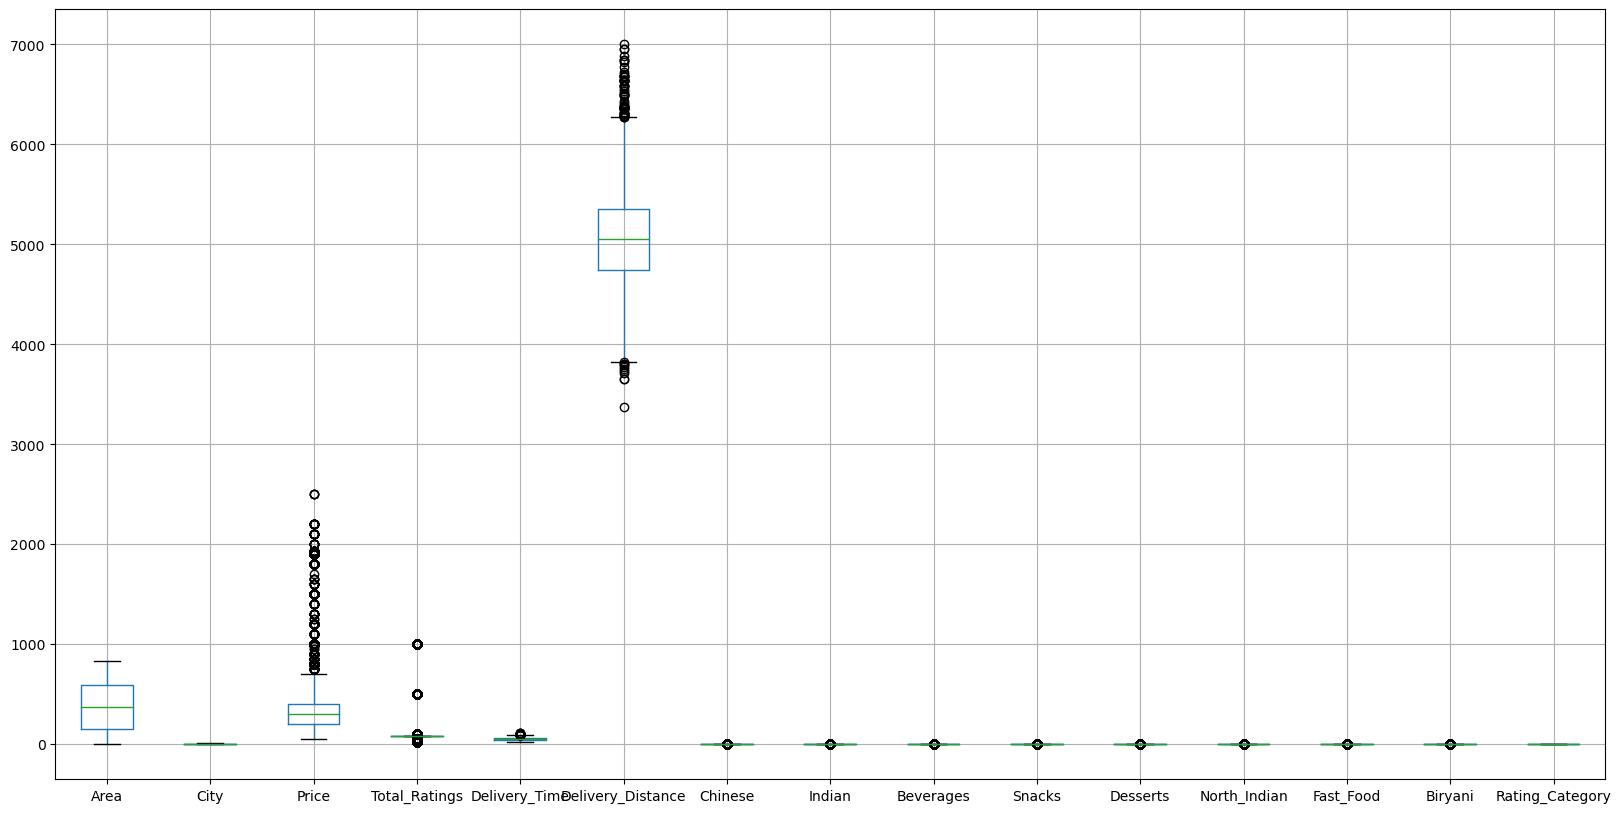

In [46]:
oversampled_df.boxplot(figsize=(20,10))
plt.show()

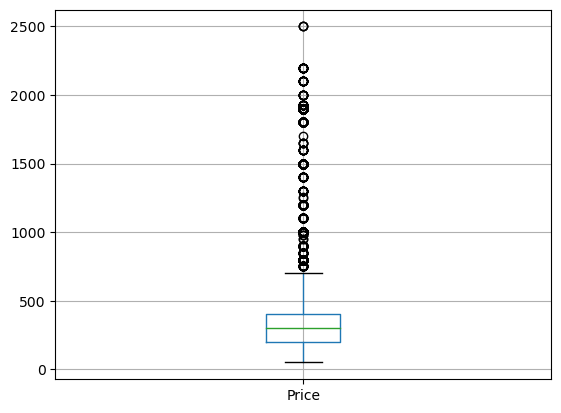

In [47]:
oversampled_df.boxplot(column="Price")
plt.show()

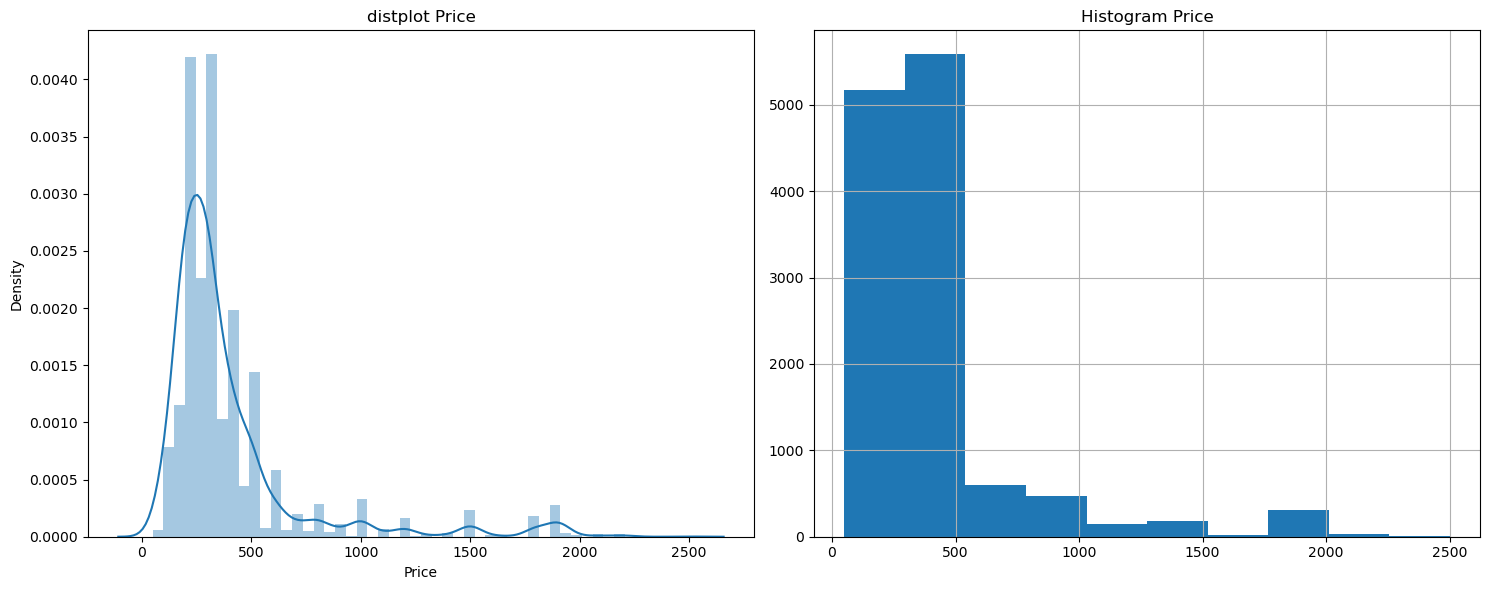

In [48]:
histdist(oversampled_df,'Price')

In [49]:
iqrdf(oversampled_df,'Price',multiplier = 3)

IQR - 200.0
Lower Boundary:  -400.0
Upper Boundary:  1000.0
Number of outliers below the lower boundary: 0
Number of outliers above the upper boundary: 674


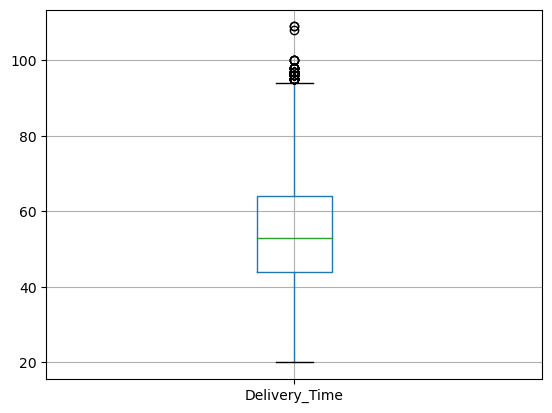

In [50]:
oversampled_df.boxplot(column="Delivery_Time")
plt.show()

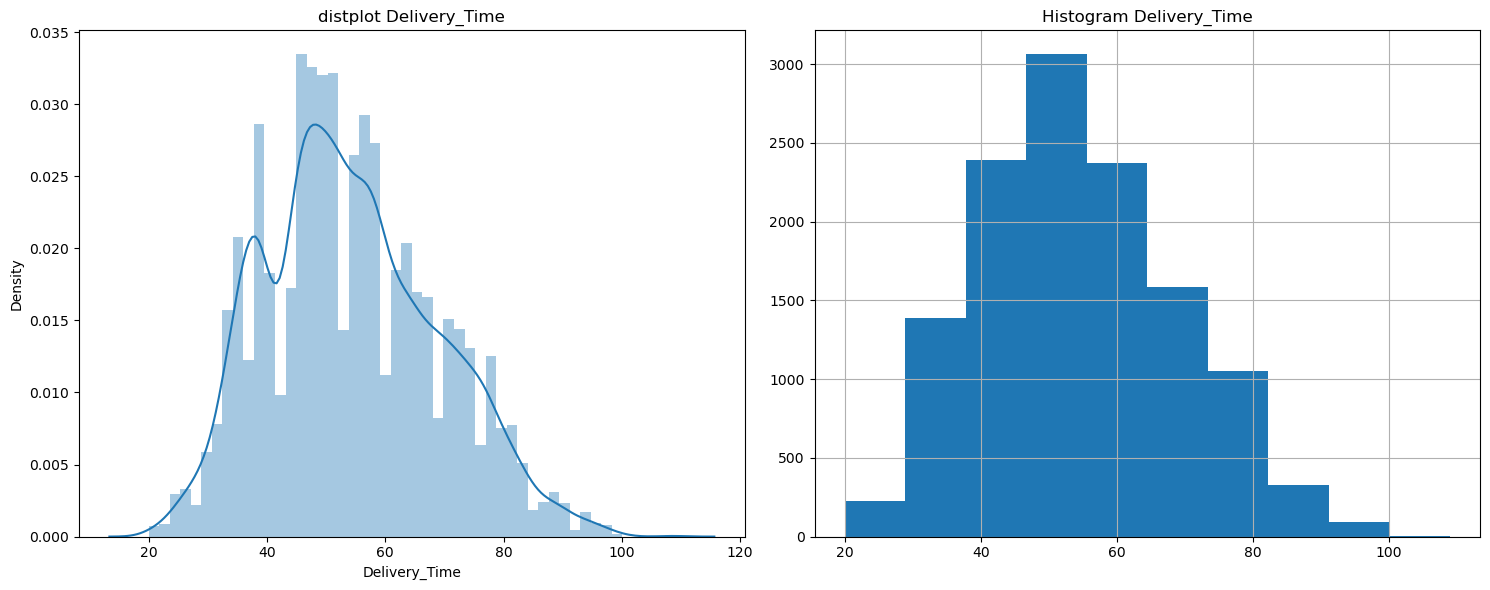

In [51]:
histdist(oversampled_df,'Delivery_Time')

Text(0.5, 1.0, 'distplot Delivery_Time')

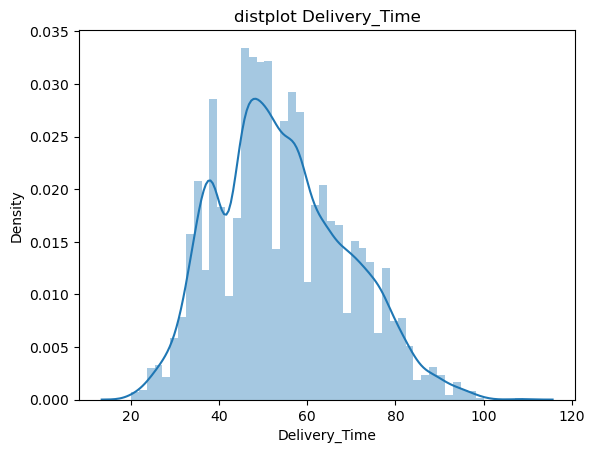

In [52]:
column='Delivery_Time'
sns.distplot(oversampled_df[column])
plt.ticklabel_format(style='plain', axis='x')
plt.title('distplot ' + column)

In [53]:
stddf(oversampled_df,'Delivery_Time',multiplier = 3)

Column Name: Delivery_Time
Lower Boundary: 10.494657700240552
Upper Boundary: 98.15439769521254
Number of outliers below the lower boundary: 0
Number of outliers above the upper boundary: 7


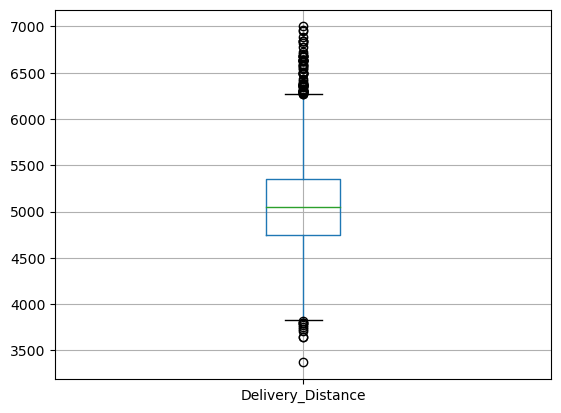

In [54]:
oversampled_df.boxplot(column="Delivery_Distance")
plt.show()

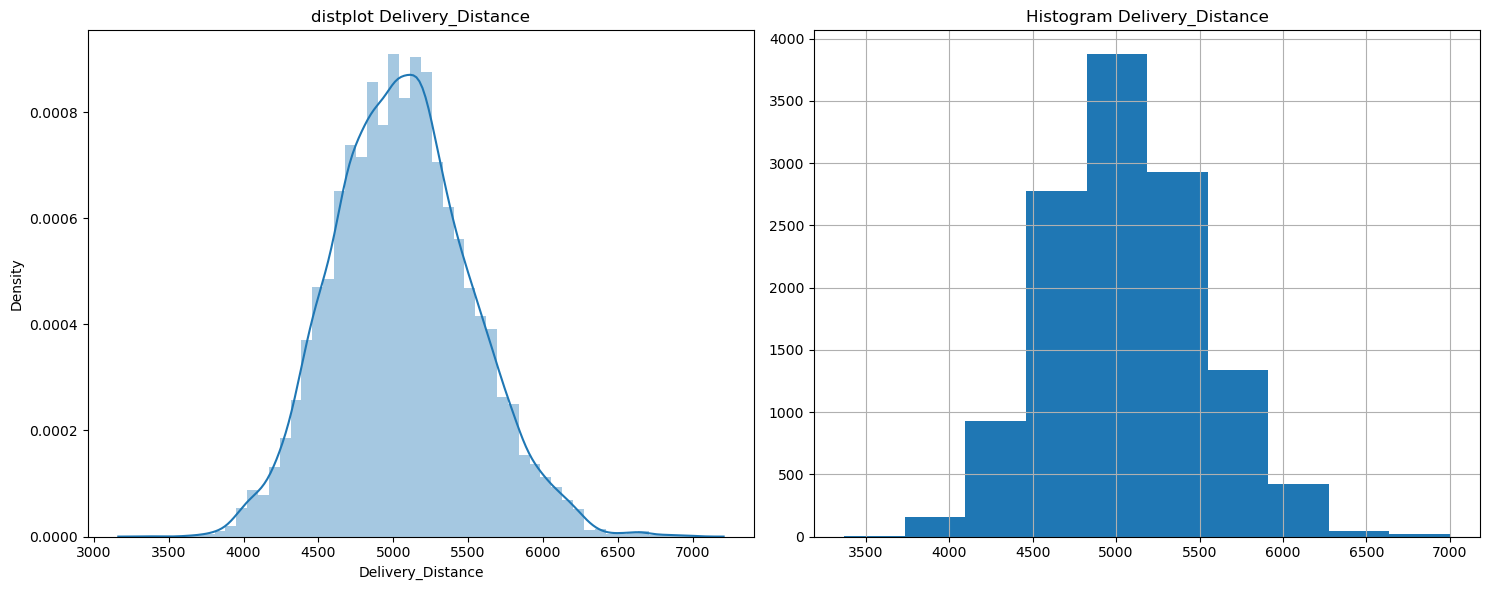

In [55]:
histdist(oversampled_df,'Delivery_Distance')

In [56]:
stddf(oversampled_df,'Delivery_Distance',multiplier = 3)

Column Name: Delivery_Distance
Lower Boundary: 3692.8578992561916
Upper Boundary: 6430.515779898468
Number of outliers below the lower boundary: 3
Number of outliers above the upper boundary: 36


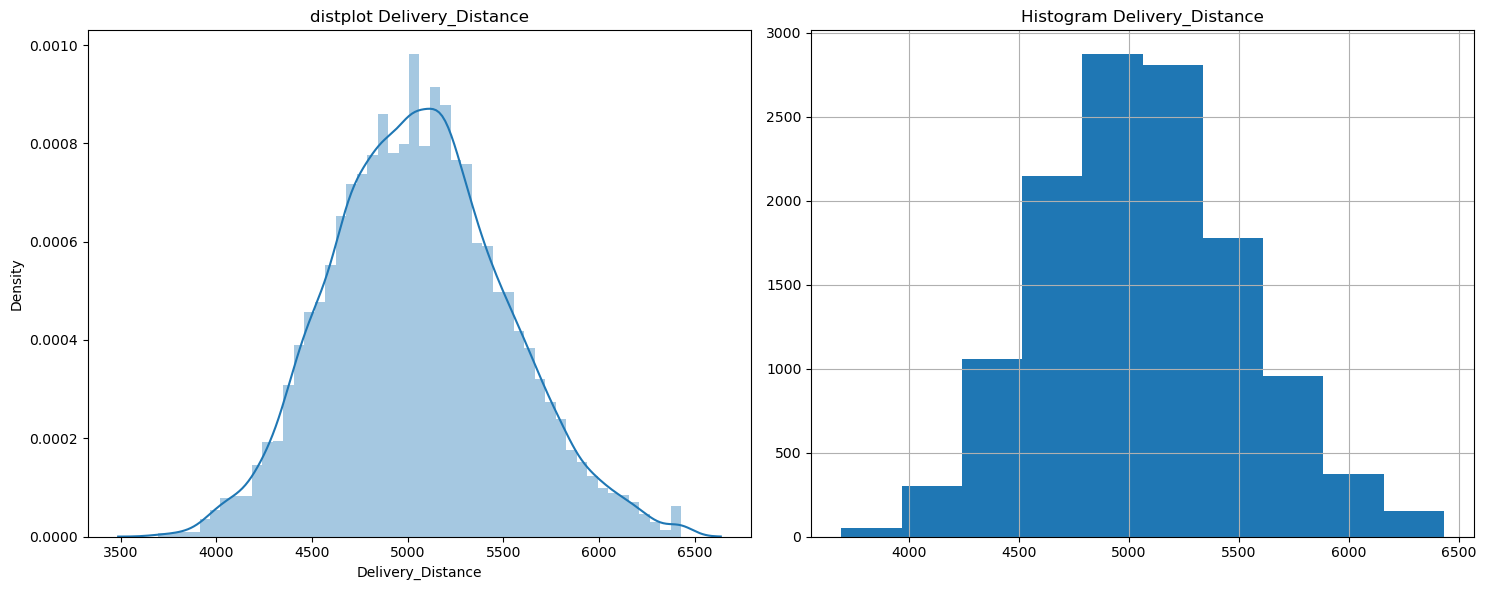

In [57]:
histdist(oversampled_df,'Delivery_Distance')

--------------------
## 6.2 Skewness treatment

In [58]:
def skewcol(df, column_name):
    # Log Transform
    log_transformed = np.log(df[column_name])

    # Square Root Transform
    sqrt_transformed = np.sqrt(df[column_name])

    # Cube Root Transform
    cbrt_transformed = np.cbrt(df[column_name])

    # Calculate Skewness for each transformation
    original_skewness = df[column_name].skew()
    log_skewness = log_transformed.skew()
    sqrt_skewness = sqrt_transformed.skew()
    cbrt_skewness = cbrt_transformed.skew()

    # Display the skewness values
    print("Column name:- ",column_name)
    print("Original Data Skewness:", original_skewness)
    print("Log Transform Skewness:", log_skewness)
    print("Square Root Transform Skewness:", sqrt_skewness)
    print("Cube Root Transform Skewness:", cbrt_skewness)

In [59]:
oversampled_df.skew()

Area                 0.084719
City                -0.188829
Price                1.647163
Total_Ratings        3.596553
Delivery_Time        0.363305
Delivery_Distance    0.191374
Chinese              1.860546
Indian               1.583583
Beverages            1.590912
Snacks               2.343740
Desserts             1.801501
North_Indian         2.051400
Fast_Food            1.574972
Biryani              2.221831
Rating_Category      0.000000
dtype: float64

In [60]:
skewcol(oversampled_df,'Price')

Column name:-  Price
Original Data Skewness: 1.6471628976060537
Log Transform Skewness: 0.3618449377892908
Square Root Transform Skewness: 1.076664657906391
Cube Root Transform Skewness: 0.8550393317452366


In [61]:
oversampled_df["Price"] = np.sqrt(oversampled_df["Price"])

-------------------
## 6.3 Visualization

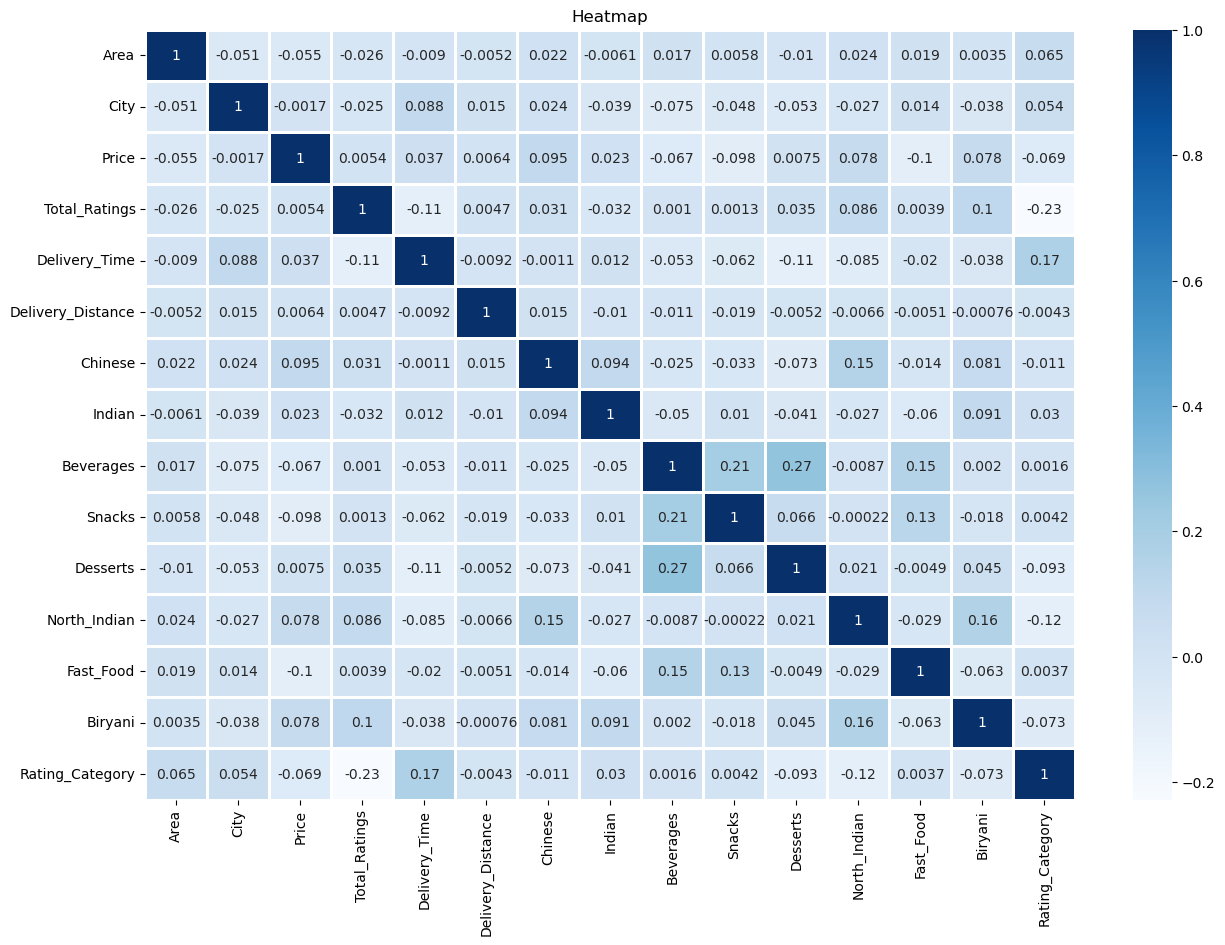

In [62]:
da1 = oversampled_df.corr()
#da1
plt.figure(figsize=(15,10))
heatmap=sns.heatmap(da1,linewidth=1,annot=True,cmap=plt.cm.Blues)
plt.title("Heatmap")
plt.show()

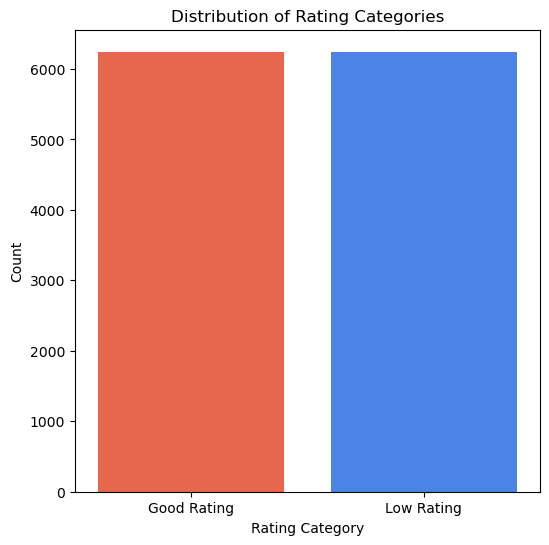

In [63]:
custom_colors = ['#FF5733', '#337DFF']
plt.figure(figsize=(6, 6))
sns.countplot(data=oversampled_df, x='Rating_Category', palette=custom_colors)

plt.xticks([0, 1], ['Good Rating', 'Low Rating'])

plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.title('Distribution of Rating Categories')

plt.show()

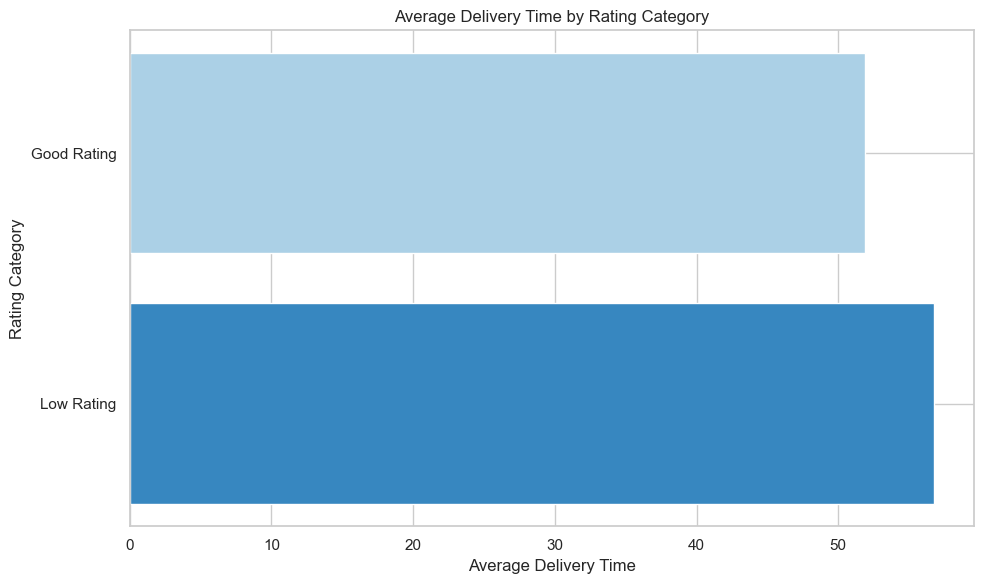

In [64]:
# Group the DataFrame by 'Rating Category' and calculate the average delivery time in each category
average_delivery_time = oversampled_df.groupby('Rating_Category')['Delivery_Time'].mean().reset_index()

# Sort the categories by average delivery time in descending order
average_delivery_time = average_delivery_time.sort_values('Delivery_Time', ascending=False)

# Create a custom color palette with a gradient
colors = sns.color_palette("Blues", n_colors=len(average_delivery_time))
colors.reverse()  # Reverse the order of colors for the gradient

# Create a horizontal bar chart with the custom color palette using barh
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.barh(average_delivery_time['Rating_Category'].map({0: 'Good Rating', 1: 'Low Rating'}), average_delivery_time['Delivery_Time'], color=colors)
plt.title('Average Delivery Time by Rating Category')
plt.xlabel('Average Delivery Time')
plt.ylabel('Rating Category')
plt.tight_layout()
plt.show()


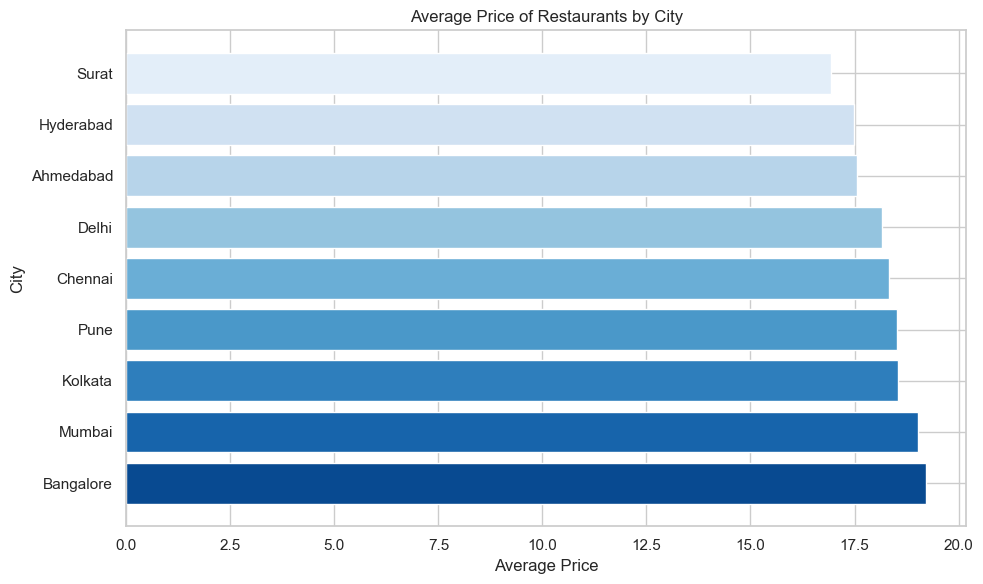

In [65]:
# Original city names mapping
city_mapping = {0: 'Ahmedabad', 1: 'Bangalore',
                2: 'Chennai', 3: 'Delhi',
                4: 'Hyderabad', 5: 'Kolkata',
                6: 'Mumbai', 7: 'Pune', 8: 'Surat'}

# Group the DataFrame by 'City' and calculate the average price in each city
average_prices = oversampled_df.groupby('City')['Price'].mean().reset_index()

# Sort the cities by average price in descending order
average_prices = average_prices.sort_values('Price', ascending=False)

# Map encoded city values to original city names
average_prices['City'] = average_prices['City'].map(city_mapping)

# Create a custom color palette with a gradient
colors = sns.color_palette("Blues", n_colors=len(average_prices))
colors.reverse()  # Reverse the order of colors for the gradient

# Create a horizontal bar chart with the custom color palette using barh
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
plt.barh(average_prices['City'], average_prices['Price'], color=colors) 
plt.title('Average Price of Restaurants by City')
plt.xlabel('Average Price')
plt.ylabel('City')
plt.tight_layout()
plt.show()

## Observation

- **Bangalore** has the **highest average restaurant price** among all the cities, making it the most expensive city for dining out.
- Conversely, **Surat** has the **lowest average restaurant price**, indicating that it is the most budget-friendly city for dining.

----------------

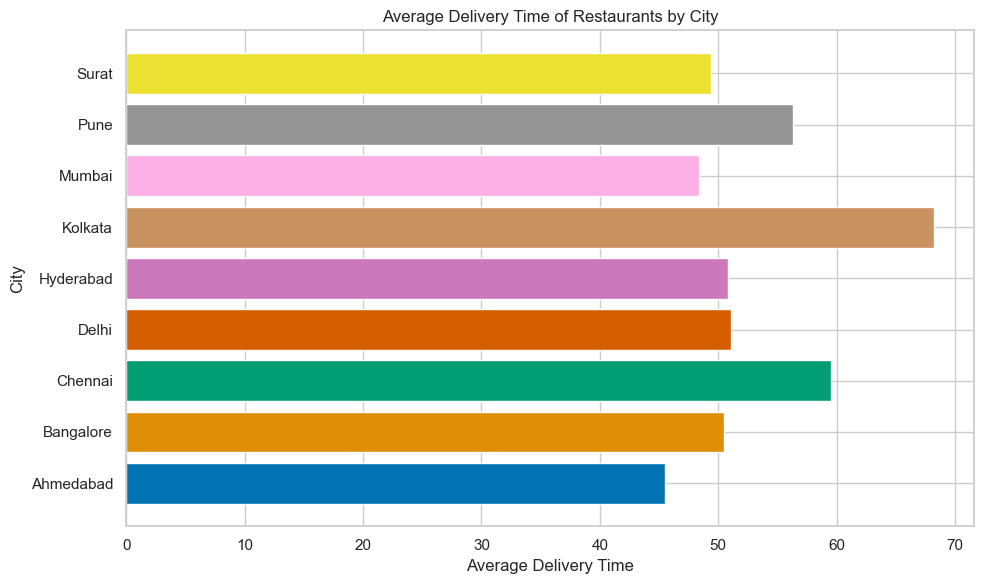

In [66]:
# Original city names mapping
city_mapping = {0: 'Ahmedabad', 1: 'Bangalore',
                2: 'Chennai', 3: 'Delhi',
                4: 'Hyderabad', 5: 'Kolkata',
                6: 'Mumbai', 7: 'Pune', 8: 'Surat'}

# Group the DataFrame by 'City' and calculate the average price in each city
average_Delivery_Time = oversampled_df.groupby('City')['Delivery_Time'].mean().reset_index()

average_Delivery_Time['City'] = average_Delivery_Time['City'].map(city_mapping)
colors = sns.color_palette("colorblind", n_colors=len(average_Delivery_Time))

plt.figure(figsize=(10, 6))
plt.barh(average_Delivery_Time['City'], average_Delivery_Time['Delivery_Time'], color=colors)
plt.title('Average Delivery Time of Restaurants by City')
plt.xlabel('Average Delivery Time')
plt.ylabel('City')
plt.tight_layout()
plt.show()

## Observation

- **Kolkata** stands out with the **highest average delivery time** among all the cities. 
- This suggests that restaurants in Kolkata may have longer delivery times on average compared to other cities, potentially due to factors such as traffic or distance.
- In contrast, **Ahmedabad has the lowest average delivery time**. This indicates that restaurants in Ahmedabad tend to deliver orders relatively quickly compared to the other cities in the dataset.

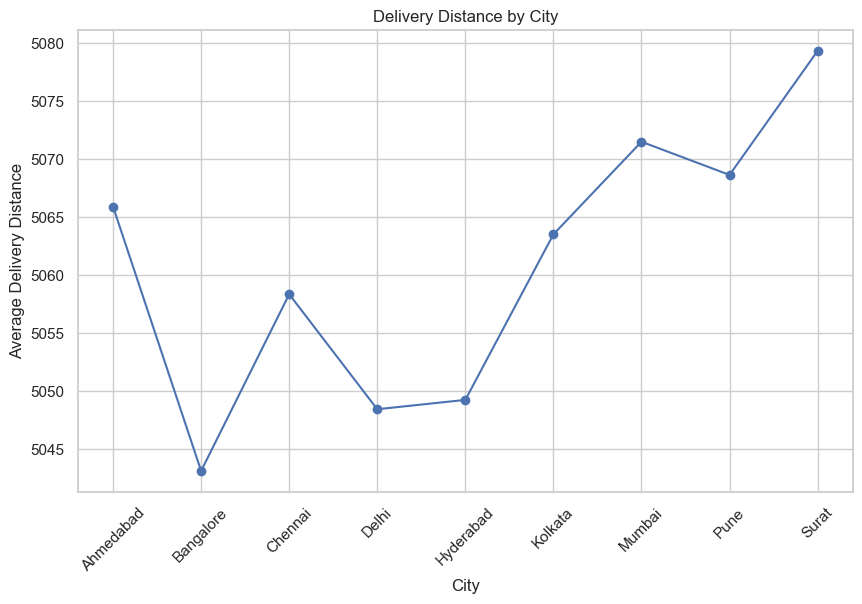

In [67]:
# Original city names mapping
city_mapping = {0: 'Ahmedabad', 1: 'Bangalore',
                2: 'Chennai', 3: 'Delhi',
                4: 'Hyderabad', 5: 'Kolkata',
                6: 'Mumbai', 7: 'Pune', 8: 'Surat'}

# Group the DataFrame by 'City' and calculate the average price in each city
city_delivery_distance  = oversampled_df.groupby('City')['Delivery_Distance'].mean().reset_index()
city_delivery_distance['City'] = city_delivery_distance['City'].map(city_mapping)

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(city_delivery_distance['City'], city_delivery_distance['Delivery_Distance'], marker='o', linestyle='-')
plt.title('Delivery Distance by City')
plt.xlabel('City')
plt.ylabel('Average Delivery Distance')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

---------------------------
# splitting the data in to X & Y  after outlier treatment

In [68]:
#splitting the data in to X & Y 
x2=oversampled_df.drop('Rating_Category', axis=1)
x2.head(2)

,Area,City,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Chinese,Indian,Beverages,Snacks,Desserts,North_Indian,Fast_Food,Biryani
0,353,1,17.320508,100,59.0,4595.0,1,0,0,0,0,1,0,1
1,353,1,17.320508,100,56.0,5411.0,0,0,0,0,0,0,0,0


In [69]:
y2=oversampled_df['Rating_Category']
y2.head(2)

0    0
1    0
Name: Rating_Category, dtype: int32

In [70]:
from sklearn.model_selection import train_test_split

x2train, x2test, y2train, y2test = train_test_split(
    x2, y2, test_size=0.2, random_state=30
)
x2train.shape, x2test.shape, y2train.shape, y2test.shape

((9993, 14), (2499, 14), (9993,), (2499,))

-------------------------
# 7. Model Building After EDA

------------------------------------
### Logistic Regression on base model after outlier treatment

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lg = LogisticRegression()
lg.fit(x2train, y2train)
log_p_eda = lg.predict(x2test)
log_cf_eda = confusion_matrix(log_p_eda, y2test)
log_acc_eda = log_cf_eda.diagonal().sum() / log_cf_eda.sum() * 100
calculate_precision_and_report(log_p_eda, y2test, model_name='log', data_type='eda')

print("Logistic Regression after EDA (Exploratory Data Analysis)\n")
print(f"Accuracy: {log_acc_eda:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(log_cf_eda)
print("-" * 80, "\nClassification Report:")
print(classification_report(log_p_eda, y2test))
# print(f'Precision for Class 0: {log_precision0_eda}')
# print(f'Precision for Class 1: {log_precision1_eda}')


Logistic Regression after EDA (Exploratory Data Analysis)

Accuracy: 59.82%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[665 409]
 [595 830]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57      1074
           1       0.67      0.58      0.62      1425

    accuracy                           0.60      2499
   macro avg       0.60      0.60      0.60      2499
weighted avg       0.61      0.60      0.60      2499



------------------------
### Decision tree on base model after outlier treatment

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

dt = DecisionTreeClassifier()
dt.fit(x2train, y2train)
dt_p_eda = dt.predict(x2test)
imp = dt.feature_importances_
dt_cf_eda = confusion_matrix(dt_p_eda, y2test)
dt_acc_eda = dt_cf_eda.diagonal().sum() / dt_cf_eda.sum() * 100
calculate_precision_and_report(dt_p_eda, y2test, model_name='dt', data_type='eda')

print("Decision Tree after EDA (Exploratory Data Analysis)\n")
print(f"Accuracy: {dt_acc_eda:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(dt_cf_eda)
print("-" * 80, "\nClassification Report:")
print(classification_report(dt_p_eda, y2test))
# print(f'Precision for Class 0: {dt_precision0_eda}')
# print(f'Precision for Class 1: {dt_precision1_eda}')

Decision Tree after EDA (Exploratory Data Analysis)

Accuracy: 94.04%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1148   37]
 [ 112 1202]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1185
           1       0.97      0.91      0.94      1314

    accuracy                           0.94      2499
   macro avg       0.94      0.94      0.94      2499
weighted avg       0.94      0.94      0.94      2499



-----------------------------------
### Random Forest on base model after outlier treatment

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=rf.n_estimators, 
                            max_depth=rf.max_depth,
                            min_samples_split=rf.min_samples_split,
                            min_samples_leaf=rf.min_samples_leaf)

rf.fit(x2train, y2train)
rf_p_eda = rf.predict(x2test)
rf_imp = rf.feature_importances_
rf_cf_eda = confusion_matrix(rf_p_eda, y2test)
rf_acc_eda = rf_cf_eda.diagonal().sum() / rf_cf_eda.sum() * 100
calculate_precision_and_report(rf_p_eda, y2test, model_name='rf', data_type='eda')


print("Random Forest after EDA (Exploratory Data Analysis)\n")
print(f"Accuracy: {rf_acc_eda:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(rf_cf_eda)
print("-" * 80, "\nClassification Report:")
print(classification_report(rf_p_eda, y2test))
# print(f'Precision for Class 0: {rf_precision0_eda}')
# print(f'Precision for Class 1: {rf_precision1_eda}')

Random Forest after EDA (Exploratory Data Analysis)

Accuracy: 94.28%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1134   17]
 [ 126 1222]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1151
           1       0.99      0.91      0.94      1348

    accuracy                           0.94      2499
   macro avg       0.94      0.95      0.94      2499
weighted avg       0.95      0.94      0.94      2499



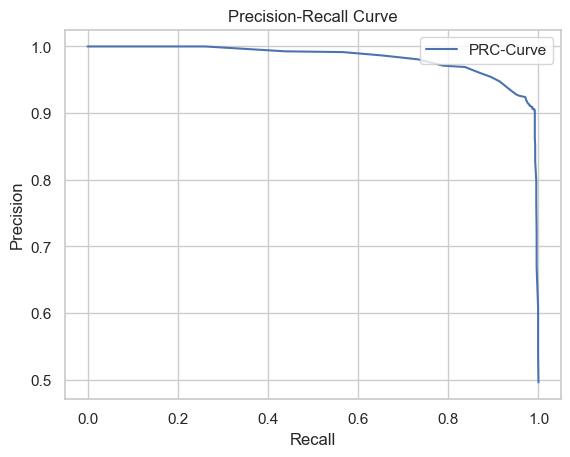

In [74]:
rf_prob_eda = rf.predict_proba(x2test)
rf_prcdf_eda = pd.DataFrame(rf_prob_eda)

# Import necessary libraries
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds for the PRC
precision, recall, thresholds = precision_recall_curve(y2test, rf_prcdf_eda.iloc[:, 1])

# Plot the Precision-Recall Curve
plt.plot(recall, precision, label="PRC-Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.title("Precision-Recall Curve")
plt.show()

----------------------------
### Naive Bayes on base model after outlier treatment

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

nb = MultinomialNB()
nb.fit(x2train, y2train)
nb_p_eda = nb.predict(x2test)
nb_cf_eda = confusion_matrix(nb_p_eda, y2test)
nb_acc_eda = nb_cf_eda.diagonal().sum() / nb_cf_eda.sum() * 100
calculate_precision_and_report(nb_p_eda, y2test, model_name='nb', data_type='eda')

# print(f'Precision for Class 0: {nb_precision0_eda}')
# print(f'Precision for Class 1: {nb_precision1_eda}')
print("Multinomial Naive Bayes after EDA (Exploratory Data Analysis)\n")
print(f"Accuracy: {nb_acc_eda:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(nb_cf_eda)
print("-" * 80, "\nClassification Report:")
print(classification_report(nb_p_eda, y2test))


Multinomial Naive Bayes after EDA (Exploratory Data Analysis)

Accuracy: 61.42%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[ 358   62]
 [ 902 1177]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.85      0.43       420
           1       0.95      0.57      0.71      2079

    accuracy                           0.61      2499
   macro avg       0.62      0.71      0.57      2499
weighted avg       0.84      0.61      0.66      2499



---------------------------------------
### XGB on base model After outlier treatment

In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

xgb = XGBClassifier()
xgb.fit(x2train, y2train)
xgb_p_eda = xgb.predict(x2test)
xgb_cf_eda = confusion_matrix(xgb_p_eda, y2test)
xgb_acc_eda = xgb_cf_eda.diagonal().sum() / xgb_cf_eda.sum() * 100
calculate_precision_and_report(xgb_p_eda, y2test, model_name='xgb', data_type='eda')

# print(f'Precision for Class 0: {xgb_precision0_eda}')
# print(f'Precision for Class 1: {xgb_precision1_eda}')
print("XGBoost after EDA (Exploratory Data Analysis)\n")
print(f"Accuracy: {xgb_acc_eda:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(xgb_cf_eda)
print("-" * 80, "\nClassification Report:")
print(classification_report(xgb_p_eda, y2test))


XGBoost after EDA (Exploratory Data Analysis)

Accuracy: 94.44%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1134   13]
 [ 126 1226]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1147
           1       0.99      0.91      0.95      1352

    accuracy                           0.94      2499
   macro avg       0.94      0.95      0.94      2499
weighted avg       0.95      0.94      0.94      2499



------------------
## Comparison dataframe of models after EDA

In [77]:
list_eda_1 = ['Logistic','DeisionTree','RandomForest','NB','XGB']
list_eda_2 = [log_acc_eda,dt_acc_eda,rf_acc_eda,nb_acc_eda,xgb_acc_eda]

list_eda_3 = [log_precision0_eda,dt_precision0_eda,rf_precision0_eda,nb_precision0_eda,xgb_precision0_eda]
list_eda_4 = [log_precision1_eda,dt_precision1_eda,rf_precision1_eda,nb_precision1_eda,xgb_precision1_eda]

list_eda_5 = [log_recall0_eda,dt_recall0_eda,rf_recall0_eda,nb_recall0_eda,xgb_recall0_eda]
list_eda_6 = [log_recall1_eda,dt_recall1_eda,rf_recall1_eda,nb_recall1_eda,xgb_recall1_eda]

list_eda_7 = [log_f1score0_eda,dt_f1score0_eda,rf_f1score0_eda,nb_f1score0_eda,xgb_f1score0_eda]
list_eda_8 = [log_f1score1_eda,dt_f1score1_eda,rf_f1score1_eda,nb_f1score1_eda,xgb_f1score1_eda]


final_2 = pd.DataFrame({'modelname':list_eda_1,'Accuracy':list_eda_2,
                        'Precision 0':list_eda_3,'Precision 1':list_eda_4,
                        'recall 0':list_eda_5,'recall 1':list_eda_6,
                        'f1score 0':list_eda_7,'f1score 1':list_eda_8
                       })
final_2

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,59.823930,0.53,0.67,0.62,0.58,0.57,0.62
1,DeisionTree,94.037615,0.91,0.97,0.97,0.91,0.94,0.94
2,RandomForest,94.277711,0.90,0.99,0.99,0.91,0.94,0.94
3,NB,61.424570,0.28,0.95,0.85,0.57,0.43,0.71
4,XGB,94.437775,0.90,0.99,0.99,0.91,0.94,0.95


# Observation
- After performing **class imbalance technique (IMB learn oversampling), outlier treatment, and skewness treatment**, we can observe **significant improvements** in **precision** compared to the base models.
- **Random-Forest & XGB** model consistently demonstrate high accuracy, precision, recall, and F1-score values across both classes.
- **Random-Forest & XGB** model excel in correctly classifying instances, with fewer false positives and a balanced trade-off between precision and recall.

# Conclusion
- **Random-Forest or  & XGB** model will be well-suited for tasks where overall accuracy and reliability in predictions are crucial.

-----------------


<br> 

# 8. Feature selection

--------------------------------------------
## RFE: Recursive Feature Elimination

In [78]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier()
rfe=RFE(dtree)
rfe.fit(x2, y2)

RFE(estimator=DecisionTreeClassifier())

In [79]:
x2.shape

(12492, 14)

In [80]:
rfe.support_

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False,  True])

In [81]:
# Create a DataFrame with selected features and corresponding column names
rfe_df = pd.DataFrame({"features": list(rfe.support_), "columns": list(x2.columns)})
rfe_df


,features,columns
0,True,Area
1,True,City
2,True,Price
3,True,Total_Ratings
4,True,Delivery_Time
5,True,Delivery_Distance
6,False,Chinese
7,False,Indian
8,False,Beverages
9,False,Snacks


In [82]:
columns_to_drop = rfe_df.loc[rfe_df['features'] == False, 'columns'].tolist()

rfe_drop = oversampled_df.drop(columns=columns_to_drop)
rfe_drop.head(2)

,Area,City,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Biryani,Rating_Category
0,353,1,17.320508,100,59.0,4595.0,1,0
1,353,1,17.320508,100,56.0,5411.0,0,0


In [83]:
rfe_drop.shape

(12492, 8)

In [84]:
rfe_drop_x=rfe_drop.drop('Rating_Category', axis=1)
rfe_drop_x.head(2)

,Area,City,Price,Total_Ratings,Delivery_Time,Delivery_Distance,Biryani
0,353,1,17.320508,100,59.0,4595.0,1
1,353,1,17.320508,100,56.0,5411.0,0


In [85]:
rfe_drop_y=rfe_drop['Rating_Category']
rfe_drop_y.head(2)

0    0
1    0
Name: Rating_Category, dtype: int32

In [86]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
x_tr_drop, x_te_drop, y_tr_drop, y_te_drop = train_test_split(
    rfe_drop_x,   # Input features
    rfe_drop_y,   # Target variable
    test_size=0.2,
    random_state=101
)

x_tr_drop.shape, x_te_drop.shape, y_tr_drop.shape, y_te_drop.shape

((9993, 7), (2499, 7), (9993,), (2499,))

-------------------------------------
# Model Building After Feature Selection

------------------------------------
### Logistic Regression after Feature Selection

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lg = LogisticRegression()
lg.fit(x_tr_drop, y_tr_drop)
log_p_fs = lg.predict(x_te_drop)
log_prob_fs = lg.predict_proba(x_te_drop)
log_cf_fs = confusion_matrix(log_p_fs, y_te_drop)
log_acc_fs = log_cf_fs.diagonal().sum() / log_cf_fs.sum() * 100
calculate_precision_and_report(log_p_fs, y_te_drop, model_name='log', data_type='fs')

# print(f'Precision for Class 0: {log_precision0_fs}')
# print(f'Precision for Class 1: {log_precision1_fs}')
print("Logistic Regression after feature selection\n")
print(f"Accuracy: {log_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(log_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(log_p_fs, y_te_drop))


Logistic Regression after feature selection

Accuracy: 58.94%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[642 403]
 [623 831]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.61      0.56      1045
           1       0.67      0.57      0.62      1454

    accuracy                           0.59      2499
   macro avg       0.59      0.59      0.59      2499
weighted avg       0.60      0.59      0.59      2499



------------------------------------
### Random Forest  after Feature Selection

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf_fs = RandomForestClassifier()
rf_fs.fit(x_tr_drop, y_tr_drop)
rf_p_fs = rf_fs.predict(x_te_drop)
rf_cf_fs = confusion_matrix(rf_p_fs, y_te_drop)
rf_acc_fs = rf_cf_fs.diagonal().sum() / rf_cf_fs.sum() * 100
calculate_precision_and_report(rf_p_fs, y_te_drop, model_name='rf', data_type='fs')

# print(f'Precision for Class 0: {rf_precision0_fs}')
# print(f'Precision for Class 1: {rf_precision1_fs}')
print("Random Forest after feature selection\n")
print(f"Accuracy: {rf_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(rf_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(rf_p_fs, y_te_drop))


Random Forest after feature selection

Accuracy: 94.96%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1151   12]
 [ 114 1222]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1163
           1       0.99      0.91      0.95      1336

    accuracy                           0.95      2499
   macro avg       0.95      0.95      0.95      2499
weighted avg       0.95      0.95      0.95      2499



### PRC CURVE

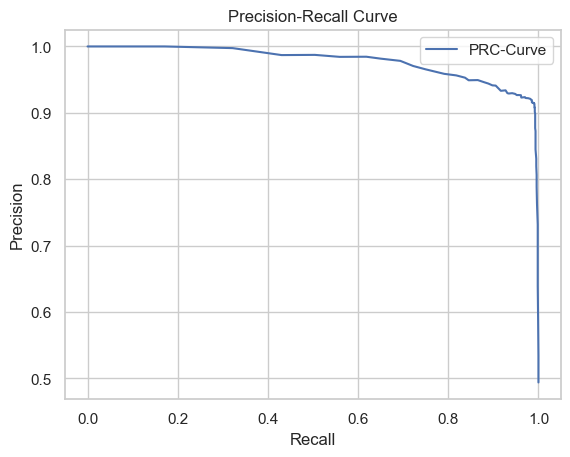

In [89]:
rf_prob_fs = rf_fs.predict_proba(x_te_drop)
rf_prcdf_fs = pd.DataFrame(rf_prob_fs)

# Import necessary libraries
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds for the PRC
precision, recall, thresholds = precision_recall_curve(y_te_drop, rf_prcdf_fs.iloc[:, 1])

# Plot the Precision-Recall Curve
plt.plot(recall, precision, label="PRC-Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="upper right")
plt.title("Precision-Recall Curve")
plt.show()

---------------------------
### Decision tree after Feature Selection

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

dt = DecisionTreeClassifier()
dt.fit(x_tr_drop, y_tr_drop)
dt_p_fs = dt.predict(x_te_drop)
imp = dt.feature_importances_
dt_cf_fs = confusion_matrix(dt_p_fs, y_te_drop)
dt_acc_fs = dt_cf_fs.diagonal().sum() / dt_cf_fs.sum() * 100
calculate_precision_and_report(dt_p_fs, y_te_drop, model_name='dt', data_type='fs')

# print(f'Precision for Class 0: {dt_precision0_fs}')
# print(f'Precision for Class 1: {dt_precision1_fs}')
print("Decision Tree after feature selection\n")
print(f"Accuracy: {dt_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(dt_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(dt_p_fs, y_te_drop))


Decision Tree after feature selection

Accuracy: 93.16%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1145   51]
 [ 120 1183]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1196
           1       0.96      0.91      0.93      1303

    accuracy                           0.93      2499
   macro avg       0.93      0.93      0.93      2499
weighted avg       0.93      0.93      0.93      2499



-----------------------------
### XGB on model after Feature Selection

In [91]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

xgb = XGBClassifier()
xgb.fit(x_tr_drop, y_tr_drop)
xgb_p_fs = xgb.predict(x_te_drop)
xgb_cf_fs = confusion_matrix(xgb_p_fs, y_te_drop)
xgb_acc_fs = xgb_cf_fs.diagonal().sum() / xgb_cf_fs.sum() * 100
calculate_precision_and_report(xgb_p_fs, y_te_drop, model_name='xgb', data_type='fs')

# print(f'Precision for Class 0: {xgb_precision0_fs}')
# print(f'Precision for Class 1: {xgb_precision1_fs}')
print("XGBoost after feature selection\n")
print(f"Accuracy: {xgb_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(xgb_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(xgb_p_fs, y_te_drop))


XGBoost after feature selection

Accuracy: 94.44%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[1145   19]
 [ 120 1215]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1164
           1       0.98      0.91      0.95      1335

    accuracy                           0.94      2499
   macro avg       0.94      0.95      0.94      2499
weighted avg       0.95      0.94      0.94      2499



----------------------------------------------
### KNN on  Feature Selection

In [92]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_tr_drop, y_tr_drop)
knn_p_fs = knn.predict(x_te_drop)
knn_cf_fs = confusion_matrix(knn_p_fs, y_te_drop)
knn_acc_fs = knn_cf_fs.diagonal().sum() / knn_cf_fs.sum() * 100
calculate_precision_and_report(knn_p_fs, y_te_drop, model_name='knn', data_type='fs')

# print(f'Precision for Class 0: {knn_precision0_fs}')
# print(f'Precision for Class 1: {knn_precision1_fs}')
print("K-Nearest Neighbors (KNN) after feature selection\n")
print(f"Accuracy: {knn_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(knn_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(knn_p_fs, y_te_drop))


K-Nearest Neighbors (KNN) after feature selection

Accuracy: 73.59%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[ 698   93]
 [ 567 1141]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.88      0.68       791
           1       0.92      0.67      0.78      1708

    accuracy                           0.74      2499
   macro avg       0.74      0.78      0.73      2499
weighted avg       0.81      0.74      0.75      2499



----------------------------
### Naive Bayes on FS

In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

nb = MultinomialNB()
nb.fit(x_tr_drop, y_tr_drop)
nb_p_fs = nb.predict(x_te_drop)
nb_cf_fs = confusion_matrix(nb_p_fs, y_te_drop)
nb_acc_fs = nb_cf_fs.diagonal().sum() / nb_cf_fs.sum() * 100
calculate_precision_and_report(nb_p_fs, y_te_drop, model_name='nb', data_type='fs')

# print(f'Precision for Class 0: {nb_precision0_fs}')
# print(f'Precision for Class 1: {nb_precision1_fs}')
print("Multinomial Naive Bayes after feature selection\n")
print(f"Accuracy: {nb_acc_fs:.2f}%")
print("-" * 80, "\nConfusion Matrix:")
print(nb_cf_fs)
print("-" * 80, "\nClassification Report:")
print(classification_report(nb_p_fs, y_te_drop))

Multinomial Naive Bayes after feature selection

Accuracy: 59.22%
-------------------------------------------------------------------------------- 
Confusion Matrix:
[[ 366  120]
 [ 899 1114]]
-------------------------------------------------------------------------------- 
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.75      0.42       486
           1       0.90      0.55      0.69      2013

    accuracy                           0.59      2499
   macro avg       0.60      0.65      0.55      2499
weighted avg       0.78      0.59      0.63      2499



In [94]:
list_FS_1 = ['Logistic','DeisionTree','RandomForest','NB','XGB']
list_FS_2 = [log_acc_fs,dt_acc_fs,rf_acc_fs,nb_acc_fs,xgb_acc_fs]

list_FS_3 = [log_precision0_fs,dt_precision0_fs,rf_precision0_fs,nb_precision0_fs,xgb_precision0_fs]
list_FS_4 = [log_precision1_fs,dt_precision1_fs,rf_precision1_fs,nb_precision1_fs,xgb_precision1_fs]

list_FS_5 = [log_recall0_fs,dt_recall0_fs,rf_recall0_fs,nb_recall0_fs,xgb_recall0_fs]
list_FS_6 = [log_recall1_fs,dt_recall1_fs,rf_recall1_fs,nb_recall1_fs,xgb_recall1_fs]

list_FS_7 = [log_f1score0_fs,dt_f1score0_fs,rf_f1score0_fs,nb_f1score0_fs,xgb_f1score0_fs]
list_FS_8 = [log_f1score1_fs,dt_f1score1_fs,rf_f1score1_fs,nb_f1score1_fs,xgb_f1score1_fs]

final_3 = pd.DataFrame({'modelname':list_FS_1,'Accuracy':list_FS_2,
                        'Precision 0':list_FS_3,'Precision 1':list_FS_4,
                        'recall 0':list_FS_5,'recall 1':list_FS_6,
                        'f1score 0':list_FS_7,'f1score 1':list_FS_8
                       })
final_3

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,58.943577,0.51,0.67,0.61,0.57,0.56,0.62
1,DeisionTree,93.157263,0.91,0.96,0.96,0.91,0.93,0.93
2,RandomForest,94.957983,0.91,0.99,0.99,0.91,0.95,0.95
3,NB,59.223689,0.29,0.90,0.75,0.55,0.42,0.69
4,XGB,94.437775,0.91,0.98,0.98,0.91,0.94,0.95


# Observation
- **After feature selection**, the models did not exhibit any major differences in their performance metrics.
- Despite the reduction in the number of features, the DecisionTree, RandomForest, and XGB models continue to demonstrate high accuracy, precision, recall, and F1-scores.

# Conclusion
- Model performance after feature selection showed **no significant changes**.
- The **RandomForest** maintains its suitability for tasks where overall accuracy and precision are crucial.

<br>

----------------------------
# Comparision

In [95]:
list_base_1 = ['Logistic','DeisionTree','RandomForest','NB','XGB']
list_base_2 = [log_acc_1,dt_acc_1,rf_acc_1,nb_acc_1,xgb_acc_1]

list_base_3 = [log_precision0_1,dt_precision0_1,rf_precision0_1,nb_precision0_1,xgb_precision0_1]
list_base_4 = [log_precision1_1,dt_precision1_1,rf_precision1_1,nb_precision1_1,xgb_precision1_1]

list_base_5 = [log_recall0_1,dt_recall0_1,rf_recall0_1,nb_recall0_1,xgb_recall0_1]
list_base_6 = [log_recall1_1,dt_recall1_1,rf_recall1_1,nb_recall1_1,xgb_recall1_1]

list_base_7 = [log_f1score0_1,dt_f1score0_1,rf_f1score0_1,nb_f1score0_1,xgb_f1score0_1]
list_base_8 = [log_f1score1_1,dt_f1score1_1,rf_f1score1_1,nb_f1score1_1,xgb_f1score1_1]


final_1 = pd.DataFrame({'modelname':list_base_1,'Accuracy':list_base_2,
                        'Precision 0':list_base_3,'Precision 1':list_base_4,
                        'recall 0':list_base_5,'recall 1':list_base_6,
                        'f1score 0':list_base_7,'f1score 1':list_base_8
                       })
#final_1

In [96]:
final_1 #Base Model

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,69.042316,0.96,0.06,0.71,0.37,0.81,0.10
1,DeisionTree,86.804009,0.91,0.78,0.91,0.78,0.91,0.78
2,RandomForest,91.870824,0.91,0.93,0.97,0.82,0.94,0.87
3,NB,48.886414,0.34,0.84,0.83,0.35,0.48,0.49
4,XGB,91.592428,0.91,0.93,0.97,0.81,0.94,0.87


In [97]:
final_2 # After Class Imbalance , Outlier

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,59.823930,0.53,0.67,0.62,0.58,0.57,0.62
1,DeisionTree,94.037615,0.91,0.97,0.97,0.91,0.94,0.94
2,RandomForest,94.277711,0.90,0.99,0.99,0.91,0.94,0.94
3,NB,61.424570,0.28,0.95,0.85,0.57,0.43,0.71
4,XGB,94.437775,0.90,0.99,0.99,0.91,0.94,0.95


In [98]:
final_3 # After FS 

,modelname,Accuracy,Precision 0,Precision 1,recall 0,recall 1,f1score 0,f1score 1
0,Logistic,58.943577,0.51,0.67,0.61,0.57,0.56,0.62
1,DeisionTree,93.157263,0.91,0.96,0.96,0.91,0.93,0.93
2,RandomForest,94.957983,0.91,0.99,0.99,0.91,0.95,0.95
3,NB,59.223689,0.29,0.90,0.75,0.55,0.42,0.69
4,XGB,94.437775,0.91,0.98,0.98,0.91,0.94,0.95


<br>

------------------------
# 10. k-fold cross-validation

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # Replace with your specific model
from sklearn.model_selection import KFold, cross_val_score

k = KFold(n_splits = 5)
scores = cross_val_score(rf_fs, rfe_drop_x, rfe_drop_y, cv=k, scoring='accuracy')  # Replace x and y with your dataset

# Print the cross-validation scores
print("Cross-Validation Scores:", scores)

# Calculate and print the mean and standard deviation of the scores
mean_accuracy = np.mean(scores)
std_accuracy = np.std(scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Cross-Validation Scores: [0.94077631 0.93077231 0.92514011 0.93634908 1.        ]
Mean Accuracy: 0.9466075621601723
Standard Deviation of Accuracy: 0.027208818581708788


In [100]:
from IPython.display import Markdown

markdown_text = f"""
# Observation:

- The **k-fold cross-validation** results for the RandomForestClassifier model (rf_fs) indicate **consistent and robust performance across multiple folds**. The accuracy scores for each fold are as follows:

    - Fold 1: `{scores[0]*100:.2f}%`
    - Fold 2: `{scores[1]*100:.2f}%`
    - Fold 3: `{scores[2]*100:.2f}%`
    - Fold 4: `{scores[3]*100:.2f}%`
    - Fold 5: `{scores[4]*100:.2f}%`
-----------------
- The **mean accuracy** across all folds is approximately `{mean_accuracy*100:.2f}%`, and the **standard deviation of accuracy** is approximately `{std_accuracy*100:.2f}%`. This suggests that the model maintains a high level of accuracy, with minimal variation, across different subsets of the dataset.
----------------------
- Overall, the RandomForestClassifier (rf_fs) demonstrates stable and reliable performance, making it a **promising choice for classification tasks on this dataset**. 
-----------------------
- The **low standard deviation indicates that the model is not sensitive to variations in the training and testing data splits**, further highlighting its robustness.
"""

# Display the Markdown text using IPython's Markdown function
display(Markdown(markdown_text))


# Observation:

- The **k-fold cross-validation** results for the RandomForestClassifier model (rf_fs) indicate **consistent and robust performance across multiple folds**. The accuracy scores for each fold are as follows:

    - Fold 1: `94.08%`
    - Fold 2: `93.08%`
    - Fold 3: `92.51%`
    - Fold 4: `93.63%`
    - Fold 5: `100.00%`
-----------------
- The **mean accuracy** across all folds is approximately `94.66%`, and the **standard deviation of accuracy** is approximately `2.72%`. This suggests that the model maintains a high level of accuracy, with minimal variation, across different subsets of the dataset.
----------------------
- Overall, the RandomForestClassifier (rf_fs) demonstrates stable and reliable performance, making it a **promising choice for classification tasks on this dataset**. 
-----------------------
- The **low standard deviation indicates that the model is not sensitive to variations in the training and testing data splits**, further highlighting its robustness.
